In [2]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

# ID3 Algorithm

## ID3 for Classification

In [3]:
class ID3DecisionTreeClassifier:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        # If all labels are the same, return the label
        if len(np.unique(y)) == 1:
            return y[0]

        # Stop if max depth is reached
        if self.max_depth is not None and depth >= self.max_depth:
            return np.bincount(y).argmax()

        # Find the best feature to split on
        best_feature = self._find_best_feature(X, y)
        if best_feature is None:
            return np.bincount(y).argmax()

        tree = {}
        unique_values = np.unique(X[:, best_feature])
        for value in unique_values:
            subset_indices = X[:, best_feature] == value
            subtree = self._build_tree(X[subset_indices], y[subset_indices], depth + 1)
            tree[value] = subtree

        return (best_feature, tree)

    def _find_best_feature(self, X, y):
        best_feature = None
        best_gain = -float('inf')
        base_entropy = self._entropy(y)

        n_features = X.shape[1]
        for feature in range(n_features):
            unique_values = np.unique(X[:, feature])
            new_entropy = 0
            for value in unique_values:
                subset_indices = X[:, feature] == value
                subset_entropy = self._entropy(y[subset_indices])
                new_entropy += (len(y[subset_indices]) / len(y)) * subset_entropy

            gain = base_entropy - new_entropy
            if gain > best_gain:
                best_gain = gain
                best_feature = feature

        return best_feature

    def _entropy(self, y):
        class_counts = np.bincount(y)
        probabilities = class_counts / len(y)
        entropy = -np.sum([p * np.log2(p + 1e-10) for p in probabilities if p > 0])
        return entropy

    def predict(self, X):
        return np.array([self._predict_sample(x, self.tree) for x in X])

    def _predict_sample(self, x, tree):
        if not isinstance(tree, tuple):
            return tree

        feature, subtree = tree
        feature_value = x[feature]
        if feature_value in subtree:
            return self._predict_sample(x, subtree[feature_value])
        else:
            return np.bincount(y).argmax()




In [4]:
# Load Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Discretize continuous features for ID3
X_discrete = np.copy(X)
for i in range(X.shape[1]):
    X_discrete[:, i] = np.digitize(X[:, i], bins=np.linspace(X[:, i].min(), X[:, i].max(), 5))

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_discrete, y, test_size=0.3, random_state=42)

# Train and evaluate the ID3 Decision Tree Classifier
id3_clf = ID3DecisionTreeClassifier(max_depth=3)
id3_clf.fit(X_train, y_train)
y_pred = id3_clf.predict(X_test)

id3_accuracy = accuracy_score(y_test, y_pred)

print("ID3 Classifier Accuracy:", id3_accuracy)

ID3 Classifier Accuracy: 0.9777777777777777


## ID3 for Regression

In [5]:
class ID3DecisionTreeRegressor:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        # If all labels are the same, return the label
        if len(np.unique(y)) == 1:
            return y[0]

        # Stop if max depth is reached
        if self.max_depth is not None and depth >= self.max_depth:
            return np.mean(y)

        # Find the best feature to split on
        best_feature, best_split = self._find_best_split(X, y)
        if best_feature is None:
            return np.mean(y)

        left_indices = X[:, best_feature] < best_split
        right_indices = ~left_indices

        left_tree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_tree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return (best_feature, best_split, left_tree, right_tree)

    def _find_best_split(self, X, y):
        best_feature = None
        best_split = None
        best_variance_reduction = -float('inf')
        base_variance = np.var(y)

        n_features = X.shape[1]
        for feature in range(n_features):
            splits = np.unique(X[:, feature])
            for split in splits:
                left_indices = X[:, feature] < split
                right_indices = ~left_indices

                if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
                    continue

                left_variance = np.var(y[left_indices])
                right_variance = np.var(y[right_indices])
                weighted_variance = (len(y[left_indices]) * left_variance + len(y[right_indices]) * right_variance) / len(y)

                variance_reduction = base_variance - weighted_variance
                if variance_reduction > best_variance_reduction:
                    best_variance_reduction = variance_reduction
                    best_feature = feature
                    best_split = split

        return best_feature, best_split

    def predict(self, X):
        return np.array([self._predict_sample(x, self.tree) for x in X])

    def _predict_sample(self, x, tree):
        if not isinstance(tree, tuple):
            return tree

        feature, split, left_tree, right_tree = tree
        if x[feature] < split:
            return self._predict_sample(x, left_tree)
        else:
            return self._predict_sample(x, right_tree)



In [6]:
# Load California housing dataset
california = fetch_california_housing()
X, y = california.data, california.target

# Discretize continuous features for ID3
X_discrete = np.copy(X)
for i in range(X.shape[1]):
    X_discrete[:, i] = np.digitize(X[:, i], bins=np.linspace(X[:, i].min(), X[:, i].max(), 5))

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_discrete, y, test_size=0.3, random_state=42)

# Train and evaluate the ID3 Decision Tree Regressor
id3_regressor = ID3DecisionTreeRegressor(max_depth=5)
id3_regressor.fit(X_train, y_train)
y_pred = id3_regressor.predict(X_test)

id3_mse = mean_squared_error(y_test, y_pred)

print("ID3 Regressor Mean Squared Error:",id3_mse )


ID3 Regressor Mean Squared Error: 0.6459923734006215


# C4.5 Algorithm

## C4.5 for Classification

In [7]:
class C45DecisionTreeClassifier:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        # Stop if all labels are the same
        if len(np.unique(y)) == 1:
            return y[0]

        # Stop if max depth is reached
        if self.max_depth is not None and depth >= self.max_depth:
            return np.bincount(y).argmax()

        best_feature, best_split = self._find_best_split(X, y)
        if best_feature is None:
            return np.bincount(y).argmax()

        tree = {}
        left_indices = X[:, best_feature] < best_split
        right_indices = ~left_indices

        tree['feature'] = best_feature
        tree['split'] = best_split
        tree['left'] = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        tree['right'] = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return tree

    def _find_best_split(self, X, y):
        best_feature = None
        best_split = None
        best_gain = -float('inf')
        base_entropy = self._entropy(y)

        n_features = X.shape[1]
        for feature in range(n_features):
            splits = np.unique(X[:, feature])
            for split in splits:
                left_indices = X[:, feature] < split
                right_indices = ~left_indices

                if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
                    continue

                new_entropy = 0
                for indices in [left_indices, right_indices]:
                    subset_entropy = self._entropy(y[indices])
                    new_entropy += (len(y[indices]) / len(y)) * subset_entropy

                gain = base_entropy - new_entropy
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_split = split

        return best_feature, best_split

    def _entropy(self, y):
        class_counts = np.bincount(y)
        probabilities = class_counts / len(y)
        entropy = -np.sum([p * np.log2(p + 1e-10) for p in probabilities if p > 0])
        return entropy

    def predict(self, X):
        return np.array([self._predict_sample(x, self.tree) for x in X])

    def _predict_sample(self, x, tree):
        # If the node is a leaf, return the class label
        if not isinstance(tree, dict):
            return tree

        # Access the feature and split value
        feature = tree['feature']
        split = tree['split']

        # Recursively predict on left or right subtree based on the split
        if x[feature] < split:
            return self._predict_sample(x, tree['left'])
        else:
            return self._predict_sample(x, tree['right'])



In [8]:

# Load Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train and evaluate the C4.5 Decision Tree Classifier
c45_clf = C45DecisionTreeClassifier(max_depth=3)
c45_clf.fit(X_train, y_train)
y_pred = c45_clf.predict(X_test)

c45_accuracy = accuracy_score(y_test, y_pred)

print("C4.5 Classifier Accuracy:", c45_accuracy)

C4.5 Classifier Accuracy: 0.9777777777777777


## C4.5 for Regression

In [9]:


class C45DecisionTreeRegressor:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        # Stop if all labels are the same
        if len(np.unique(y)) == 1:
            return y[0]

        # Stop if max depth is reached
        if self.max_depth is not None and depth >= self.max_depth:
            return np.mean(y)

        best_feature, best_split = self._find_best_split(X, y)
        if best_feature is None:
            return np.mean(y)

        left_indices = X[:, best_feature] < best_split
        right_indices = ~left_indices

        tree = {}
        tree['feature'] = best_feature
        tree['split'] = best_split
        tree['left'] = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        tree['right'] = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return tree

    def _find_best_split(self, X, y):
        best_feature = None
        best_split = None
        best_variance_reduction = -float('inf')
        base_variance = np.var(y)

        n_features = X.shape[1]
        for feature in range(n_features):
            splits = np.unique(X[:, feature])
            for split in splits:
                left_indices = X[:, feature] < split
                right_indices = ~left_indices

                if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
                    continue

                left_variance = np.var(y[left_indices])
                right_variance = np.var(y[right_indices])
                weighted_variance = (len(y[left_indices]) * left_variance + len(y[right_indices]) * right_variance) / len(y)

                variance_reduction = base_variance - weighted_variance
                if variance_reduction > best_variance_reduction:
                    best_variance_reduction = variance_reduction
                    best_feature = feature
                    best_split = split

        return best_feature, best_split

    def predict(self, X):
        return np.array([self._predict_sample(x, self.tree) for x in X])

    def _predict_sample(self, x, tree):
        if isinstance(tree, float):
            return tree

        feature = tree['feature']
        split = tree['split']
        if x[feature] < split:
            return self._predict_sample(x, tree['left'])
        else:
            return self._predict_sample(x, tree['right'])




In [10]:
# Load California housing dataset
california = fetch_california_housing()
X, y = california.data, california.target

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train and evaluate the C4.5 Decision Tree Regressor
c45_regressor = C45DecisionTreeRegressor(max_depth=5)
c45_regressor.fit(X_train, y_train)
y_pred = c45_regressor.predict(X_test)

c45_mse = mean_squared_error(y_test, y_pred)

print("C4.5 Regressor Mean Squared Error:", c45_mse)

C4.5 Regressor Mean Squared Error: 0.5203761515596471


# CART Algorithm

In [11]:


class DecisionTreeClassifier:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        n_samples, n_features = X.shape
        unique_classes = np.unique(y)

        # Stop condition: If all samples have the same class or max depth is reached
        if len(unique_classes) == 1 or (self.max_depth is not None and depth >= self.max_depth):
            return unique_classes[0]

        best_feature, best_threshold = self._find_best_split(X, y)
        if best_feature is None:
            return np.bincount(y).argmax()

        left_indices = X[:, best_feature] < best_threshold
        right_indices = ~left_indices

        left_tree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_tree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return (best_feature, best_threshold, left_tree, right_tree)

    def _find_best_split(self, X, y):
        best_gini = float('inf')
        best_feature = None
        best_threshold = None

        n_features = X.shape[1]
        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_indices = X[:, feature] < threshold
                right_indices = ~left_indices

                if len(np.unique(y[left_indices])) == 0 or len(np.unique(y[right_indices])) == 0:
                    continue

                gini = self._calculate_gini(y, left_indices, right_indices)
                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _calculate_gini(self, y, left_indices, right_indices):
        left_size = np.sum(left_indices)
        right_size = np.sum(right_indices)
        total_size = len(y)

        if left_size == 0 or right_size == 0:
            return float('inf')

        gini_left = 1.0 - sum((np.sum(y[left_indices] == c) / left_size) ** 2 for c in np.unique(y))
        gini_right = 1.0 - sum((np.sum(y[right_indices] == c) / right_size) ** 2 for c in np.unique(y))

        return (left_size / total_size) * gini_left + (right_size / total_size) * gini_right

    def predict(self, X):
        return np.array([self._predict_sample(x, self.tree) for x in X])

    def _predict_sample(self, x, tree):
        if not isinstance(tree, tuple):
            return tree

        feature, threshold, left_tree, right_tree = tree
        if x[feature] < threshold:
            return self._predict_sample(x, left_tree)
        else:
            return self._predict_sample(x, right_tree)




In [12]:
# Load Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train and evaluate the Decision Tree Classifier
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cart_accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:",cart_accuracy )

Accuracy: 0.7111111111111111


In [13]:

class DecisionTreeRegressor:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        n_samples, n_features = X.shape

        # Stop condition: If max depth is reached
        if depth >= self.max_depth:
            return np.mean(y)

        best_feature, best_threshold = self._find_best_split(X, y)
        if best_feature is None:
            return np.mean(y)

        left_indices = X[:, best_feature] < best_threshold
        right_indices = ~left_indices

        left_tree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_tree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return (best_feature, best_threshold, left_tree, right_tree)

    def _find_best_split(self, X, y):
        best_mse = float('inf')
        best_feature = None
        best_threshold = None

        n_features = X.shape[1]
        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_indices = X[:, feature] < threshold
                right_indices = ~left_indices

                if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
                    continue

                mse = self._calculate_mse(y, left_indices, right_indices)
                if mse < best_mse:
                    best_mse = mse
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _calculate_mse(self, y, left_indices, right_indices):
        left_size = np.sum(left_indices)
        right_size = np.sum(right_indices)

        if left_size == 0 or right_size == 0:
            return float('inf')

        mse_left = np.mean((y[left_indices] - np.mean(y[left_indices])) ** 2)
        mse_right = np.mean((y[right_indices] - np.mean(y[right_indices])) ** 2)

        total_size = len(y)
        return (left_size / total_size) * mse_left + (right_size / total_size) * mse_right

    def predict(self, X):
        return np.array([self._predict_sample(x, self.tree) for x in X])

    def _predict_sample(self, x, tree):
        if not isinstance(tree, tuple):
            return tree

        feature, threshold, left_tree, right_tree = tree
        if x[feature] < threshold:
            return self._predict_sample(x, left_tree)
        else:
            return self._predict_sample(x, right_tree)




In [14]:
# Load California housing dataset
california = fetch_california_housing()
X, y = california.data, california.target

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train and evaluate the Decision Tree Regressor
regressor = DecisionTreeRegressor(max_depth=5)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

cart_mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error:", cart_mse )

Mean Squared Error: 0.5203761515596471


# CHAID Algorithm

In [15]:
import numpy as np
from scipy.stats import chi2_contingency

class CHAIDDecisionTreeClassifier:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        n_samples, n_features = X.shape
        unique_classes = np.unique(y)

        # Stop condition: If all samples have the same class or max depth is reached
        if len(unique_classes) == 1 or (self.max_depth is not None and depth >= self.max_depth):
            return unique_classes[0]

        best_feature, best_split = self._find_best_split(X, y)
        if best_feature is None:
            return np.bincount(y).argmax()

        left_indices = X[:, best_feature] == best_split
        right_indices = ~left_indices

        left_tree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_tree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return (best_feature, best_split, left_tree, right_tree)

    def _find_best_split(self, X, y):
        best_chi2 = float('inf')
        best_feature = None
        best_split = None

        n_features = X.shape[1]
        unique_classes = np.unique(y)
        for feature in range(n_features):
            splits = np.unique(X[:, feature])
            for split in splits:
                left_indices = X[:, feature] == split
                right_indices = ~left_indices

                if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
                    continue

                left_counts = np.bincount(y[left_indices], minlength=len(unique_classes))
                right_counts = np.bincount(y[right_indices], minlength=len(unique_classes))

                if len(left_counts) != len(right_counts):
                    continue

                chi2, p, _, _ = chi2_contingency([left_counts, right_counts])

                if chi2 < best_chi2:
                    best_chi2 = chi2
                    best_feature = feature
                    best_split = split

        return best_feature, best_split

    def predict(self, X):
        return np.array([self._predict_sample(x, self.tree) for x in X])

    def _predict_sample(self, x, tree):
        if not isinstance(tree, tuple):
            return tree

        feature, split, left_tree, right_tree = tree
        if x[feature] == split:
            return self._predict_sample(x, left_tree)
        else:
            return self._predict_sample(x, right_tree)


In [16]:
# Load Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Convert to categorical values
X[:, 0] = np.digitize(X[:, 0], bins=np.linspace(X[:, 0].min(), X[:, 0].max(), 5))
X[:, 1] = np.digitize(X[:, 1], bins=np.linspace(X[:, 1].min(), X[:, 1].max(), 5))

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train and evaluate the CHAID Decision Tree Classifier
chaid_clf = CHAIDDecisionTreeClassifier(max_depth=3)
chaid_clf.fit(X_train, y_train)
y_pred = chaid_clf.predict(X_test)

chaid_accuracy = accuracy_score(y_test, y_pred)

print("CHAID Classifier Accuracy:", chaid_accuracy )

CHAID Classifier Accuracy: 0.4666666666666667


In [17]:
import numpy as np
from scipy.stats import chi2_contingency

class CHAIDDecisionTreeRegressor:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        n_samples, n_features = X.shape

        # Stop condition: If max depth is reached
        if self.max_depth is not None and depth >= self.max_depth:
            return np.mean(y)

        best_feature, best_split = self._find_best_split(X, y)
        if best_feature is None:
            return np.mean(y)

        left_indices = X[:, best_feature] < best_split
        right_indices = ~left_indices

        left_tree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_tree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return (best_feature, best_split, left_tree, right_tree)

    def _find_best_split(self, X, y):
        best_chi2 = float('inf')
        best_feature = None
        best_split = None

        n_features = X.shape[1]
        for feature in range(n_features):
            splits = np.unique(X[:, feature])
            for split in splits:
                left_indices = X[:, feature] < split
                right_indices = ~left_indices

                if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
                    continue

                left_hist, _ = np.histogram(y[left_indices], bins=10)
                right_hist, _ = np.histogram(y[right_indices], bins=10)

                # Combine non-zero counts and ensure the table is valid for chi2_contingency
                left_hist = left_hist + 1  # Add a small value to avoid zero counts
                right_hist = right_hist + 1

                contingency_table = [left_hist, right_hist]

                try:
                    chi2, p, _, _ = chi2_contingency(contingency_table)
                except ValueError:
                    continue

                if chi2 < best_chi2:
                    best_chi2 = chi2
                    best_feature = feature
                    best_split = split

        return best_feature, best_split

    def predict(self, X):
        return np.array([self._predict_sample(x, self.tree) for x in X])

    def _predict_sample(self, x, tree):
        if not isinstance(tree, tuple):
            return tree

        feature, split, left_tree, right_tree = tree
        if x[feature] < split:
            return self._predict_sample(x, left_tree)
        else:
            return self._predict_sample(x, right_tree)


In [18]:
# Load California housing dataset
california = fetch_california_housing()
X, y = california.data, california.target

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train and evaluate the CHAID Decision Tree Regressor
chaid_regressor = CHAIDDecisionTreeRegressor(max_depth=5)
chaid_regressor.fit(X_train, y_train)
y_pred = chaid_regressor.predict(X_test)

chaid_mse = mean_squared_error(y_test, y_pred)

print("CHAID Regressor Mean Squared Error:", chaid_mse)

CHAID Regressor Mean Squared Error: 1.3141655592654407


#Scikit Learn Decision Tree

## Classification

Decision Tree Classifier Accuracy: 1.00


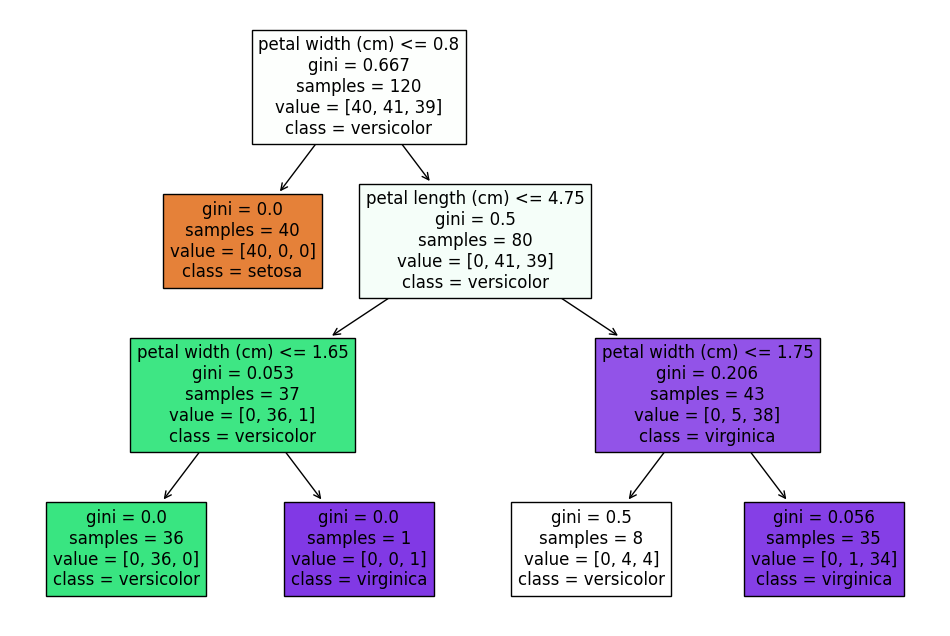

In [19]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree Classifier
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the classifier
scikit_accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Classifier Accuracy: {scikit_accuracy:.2f}")

# Visualize the decision tree
plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=iris.feature_names, class_names=iris.target_names, filled=True)
plt.show()


## Regression

Decision Tree Regressor Mean Squared Error: 0.52


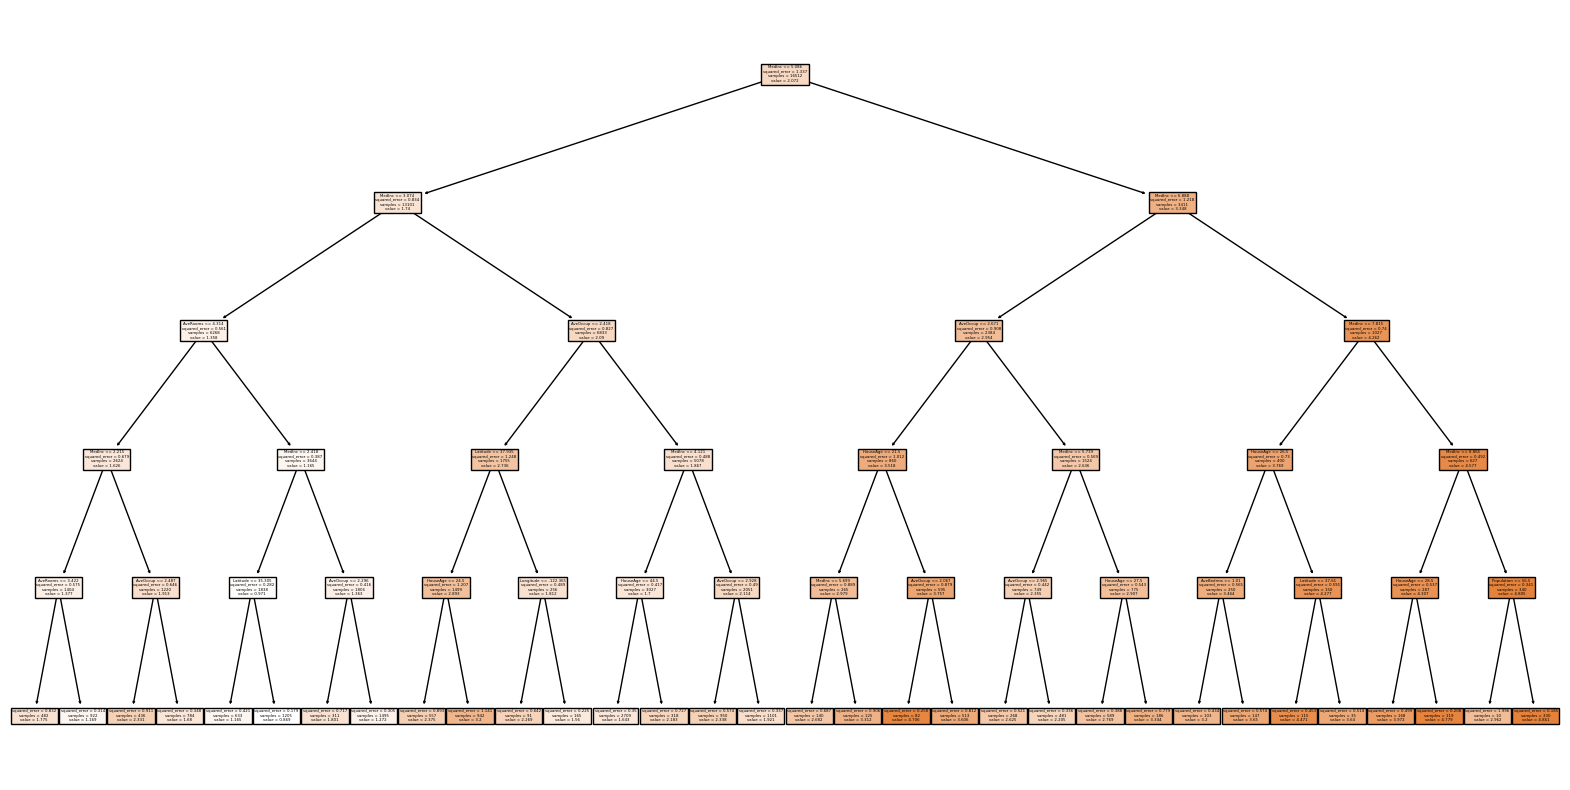

In [20]:
from sklearn.tree import DecisionTreeRegressor


# Load the California Housing dataset
california = fetch_california_housing()
X = california.data
y = california.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree Regressor
reg = DecisionTreeRegressor(max_depth=5)
reg.fit(X_train, y_train)

# Make predictions
y_pred = reg.predict(X_test)

# Evaluate the regressor
scikit_mse = mean_squared_error(y_test, y_pred)
print(f"Decision Tree Regressor Mean Squared Error: {scikit_mse:.2f}")

# Optional: Visualize the decision tree (only feasible if max_depth is small)
plt.figure(figsize=(20, 10))
plot_tree(reg, feature_names=california.feature_names, filled=True)
plt.show()


# Compare

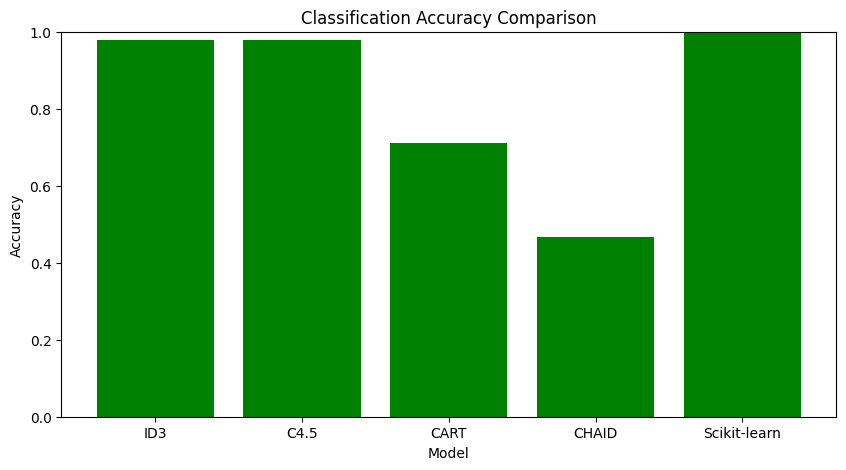

In [22]:

accuracy_scores = {
    'ID3': id3_accuracy,
    'C4.5': c45_accuracy,
    'CART': cart_accuracy,
    'CHAID': chaid_accuracy,
    'Scikit-learn': scikit_accuracy
}


# Plot accuracy scores
plt.figure(figsize=(10, 5))
plt.bar(accuracy_scores.keys(), accuracy_scores.values(),color='green')
plt.title('Classification Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.show()

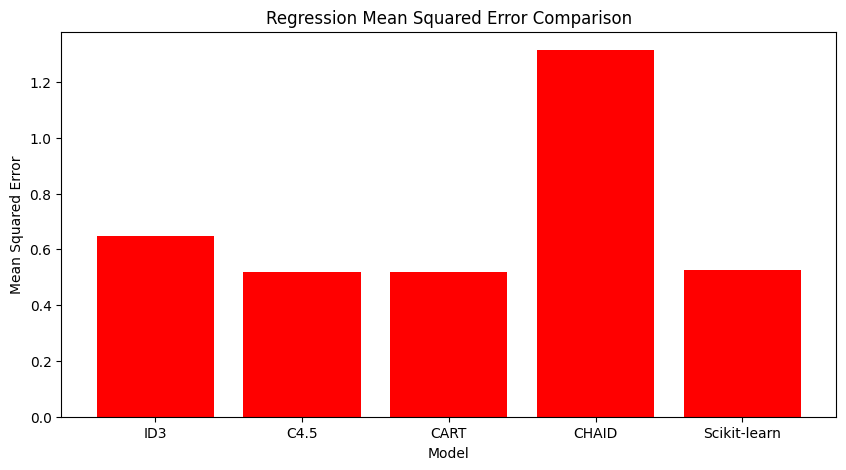

In [23]:

mse_scores = {
    'ID3': id3_mse,
    'C4.5': c45_mse,
    'CART': cart_mse,
    'CHAID': chaid_mse,
    'Scikit-learn': scikit_mse
}


# Plot mean squared error scores
plt.figure(figsize=(10, 5))
plt.bar(mse_scores.keys(), mse_scores.values(), color='red')
plt.title('Regression Mean Squared Error Comparison')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error')
plt.show()